### Microplaces and Violence  
  
Violent crime in America rose in 2020. The Economist suggested in a June 5th article, "Reality bites" that crime is geographically concentrated in certain neighborhoods. 
  
The Department of Public Safety in Denver, CO responded with a letter stating that "violence is just concentrated in just a few microplaces, each about two blocks square. In Denver 38 microplaces, equivalent to 1.5% of our landmass, accounted for about 25% of all violence in 2020."  
  
Can we say the same of Chicago, IL?   

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import fidap
from config import api_key
from shapely import wkt


# instantiate api connection
fidap = fidap.fidap_client(api_key=api_key)

In [66]:
chicago_violent_crime_2020 = fidap.sql("""
SELECT case_number, primary_type, ST_GEOGPOINT(longitude, latitude) AS geometry, date, description  
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2020
AND location IS NOT NULL
AND primary_type IN ('HOMICIDE', 'CRIME SEXUAL ASSAULT', 'ROBBERY', 'BATTERY', 'ASSAULT', 'ARSON', 'KIDNAPPING', 'INTIMIDATION')
""")

In [67]:
chicago_violent_crime_2020_gdf = chicago_violent_crime_2020.copy()
chicago_violent_crime_2020_gdf['geometry'] = chicago_violent_crime_2020_gdf['geometry'].apply(wkt.loads)
chicago_violent_crime_2020_gdf = gpd.GeoDataFrame(chicago_violent_crime_2020_gdf, geometry='geometry', crs = 'epsg:4326')

Potential Avenues Moving Forward:  
1) KMeans to identify clusters  
2) Group them by census block groups to identify block groups that are particularly vulnerable to such crime  
3) Figure out why?  

First, we should aggregate them by Chicago's wards to identify wards where violent crime counts a lot higher. 

In [59]:
# count of crime by ward
chicago_violent_crime_2020_ward = fidap.sql("""
SELECT COUNT(*) AS crime_count, ward
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2020
AND primary_type IN ('HOMICIDE', 'CRIME SEXUAL ASSAULT', 'ROBBERY', 'BATTERY', 'ASSAULT', 'ARSON', 'KIDNAPPING', 'INTIMIDATION')
AND location IS NOT NULL
AND ward IS NOT NULL
GROUP BY ward
""")

# change type
chicago_violent_crime_2020_ward['ward'] = chicago_violent_crime_2020_ward['ward'].astype(str)
# wards with highest violent crime count
chicago_violent_crime_2020_ward.sort_values(by = 'crime_count', ascending=False).head(n = 5)

,crime_count,ward
40,3921,28
41,3449,24
44,3207,6
43,2728,20
46,2699,17


What does this actually look like on a map? 

In [25]:
# get chicago's wards boundaries
chicago_wards_url = "https://data.cityofchicago.org/api/geospatial/sp34-6z76?method=export&format=Shapefile"
chicago_wards = gpd.read_file(chicago_wards_url)

# chicago population by census block
chicago_pop_census_block_url = "https://data.cityofchicago.org/resource/5yjb-v3mj.csv"
chicago_pop_census_block = pd.read_csv(chicago_pop_census_block_url)

# chicago census_blocks boundaries
chicago_census_blocks_url = "https://data.cityofchicago.org/api/geospatial/mfzt-js4n?method=export&format=Shapefile"
chicago_census_blocks = gpd.read_file(chicago_census_blocks_url)

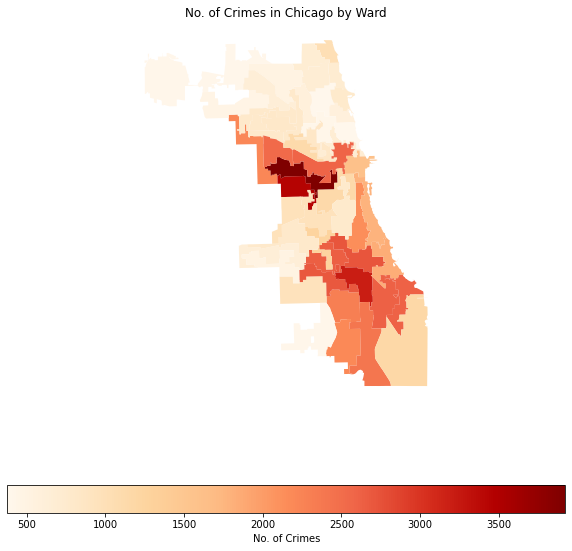

In [38]:
# join count of crime by ward to wards
chicago_wards_crime_count = chicago_wards.copy().merge(chicago_violent_crime_2020_ward)

# plot 
f, ax = plt.subplots(figsize = (10,10))
chicago_wards_crime_count.plot(ax = ax, column = 'crime_count', legend = True, cmap = "OrRd", 
                               legend_kwds = {
                                   'label': 'No. of Crimes',
                                   'orientation': 'horizontal'
                               })
ax.set_axis_off()
ax.set_title("No. of Crimes in Chicago by Ward")
plt.show()

It appears that there is some sort of spatial contiguity and concentration where crimes are concerned. Clearly, the rate of occurrence in some rates is a lot higher than others, and there is a stark difference among the wards in Chicago. What if we map it at the scale of Census block groups?  

In [32]:
chicago_crime_by_blockgroup = fidap.sql("""
WITH chicago_blocks AS(
SELECT geo_id, blockgroup_geom 
FROM bigquery-public-data.geo_census_blockgroups.blockgroups_17
WHERE county_fips_code = '031'
)

SELECT COUNT(*) AS crime_count, z.geo_id 
FROM bigquery-public-data.chicago_crime.crime AS c, chicago_blocks AS z
WHERE c.year = 2020
AND c.location IS NOT NULL
AND ST_CONTAINS(z.blockgroup_geom, ST_GEOGPOINT(c.longitude, c.latitude))
AND primary_type IN ('HOMICIDE', 'CRIME SEXUAL ASSAULT', 'ROBBERY', 'BATTERY', 'ASSAULT', 'ARSON', 'KIDNAPPING', 'INTIMIDATION')
AND ward IS NOT NULL
GROUP BY z.geo_id;
""")


In [27]:
# converting to string
chicago_crime_by_blockgroups = chicago_crime_by_blockgroup.copy().assign(
    blockgroup_geoid = lambda x: x.geo_id.astype(str)
)

# obtain census blocks
chicago_census_blocks['blockgroup_geoid'] = chicago_census_blocks['geoid10'].str[:12]

# group and dissolve  by census blocks
chicago_census_blockgroups = chicago_census_blocks.copy().dissolve(by = 'blockgroup_geoid')
chicago_census_blockgroups = chicago_census_blockgroups.reset_index()
chicago_census_blockgroups = chicago_census_blockgroups.loc[:, ['blockgroup_geoid', 'geometry']]

# merging with census blocks sql query
chicago_crime_blockgroup_count = chicago_census_blockgroups.merge(chicago_crime_by_blockgroups, on = 'blockgroup_geoid', how = 'left')

Let us plot the number of crimes by wards and census block groups side by side and by quintiles to see how they compare. 

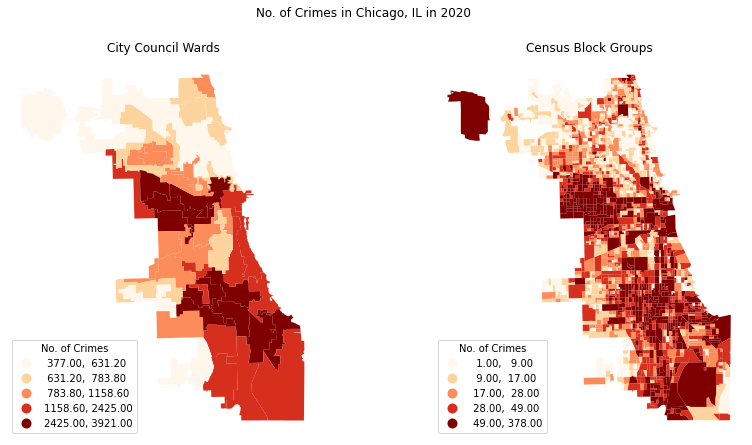

In [43]:
# plotting
f2, ax2 = plt.subplots(1,2, figsize = (14,7))
chicago_wards_crime_count.plot(ax = ax2[0], column = 'crime_count', scheme = 'quantiles', k = 5, cmap = "OrRd",
                          legend = True, legend_kwds = {
                              'loc': 3,
                              'title': 'No. of Crimes'
                          }
                          )
chicago_crime_blockgroup_count.plot(ax = ax2[1], column = 'crime_count', scheme = 'quantiles', k = 5, cmap = "OrRd", 
                         legend = True, legend_kwds = {
                              'loc': 3,
                              'title': 'No. of Crimes'
                          })
ax2[0].set_title("City Council Wards")
ax2[1].set_title("Census Block Groups")
for ax in ax2:
    ax.set_axis_off()
f2.suptitle("No. of Crimes in Chicago, IL in 2020, by Quintile")
plt.show()

There are a few things here. Plotting it by quintile shows us that while some wards might be ranked in the first or second quintile (first 20-40%) in terms of the number of violent crimes, particular block groups in these wards might rank in the fifth quintile as in the north of Chicago. Further, if we look at the quintiles closely, the range in the fifth quintile is exceptionally huge. This can be seen in the histograms below where there is a severe right-skew in terms of the number of crimes by block groups. 

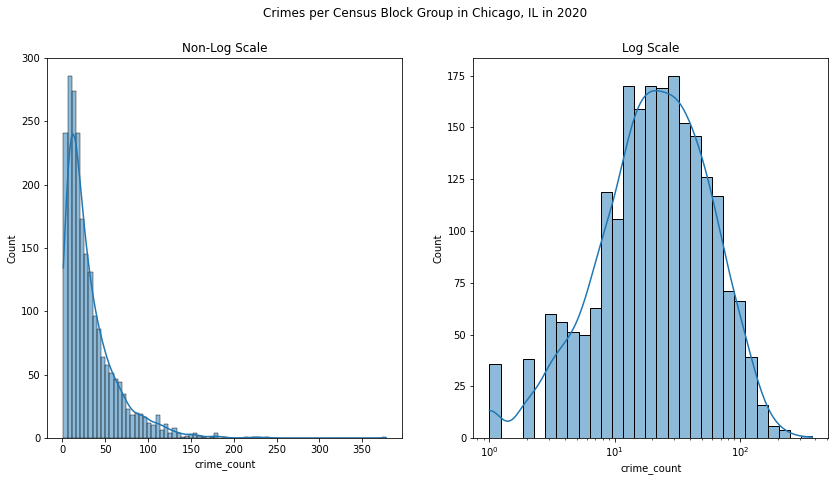

In [50]:
f3, ax3 = plt.subplots(1,2, figsize = (14,7))
sns.histplot(chicago_crime_blockgroup_count, ax = ax3[0], x = "crime_count", kde = True)
sns.histplot(chicago_crime_blockgroup_count, ax = ax3[1], x = "crime_count", kde = True, log_scale=True)
ax3[0].set_title("Non-Log Scale")
ax3[1].set_title("Log Scale")
f3.suptitle("Crimes per Census Block Group in Chicago, IL in 2020")
plt.show()

Given the extremely long tail, it might be difficult to look at the numbers with an unbinned choropleth map or at the quintile level. What if we break it down into deciles?

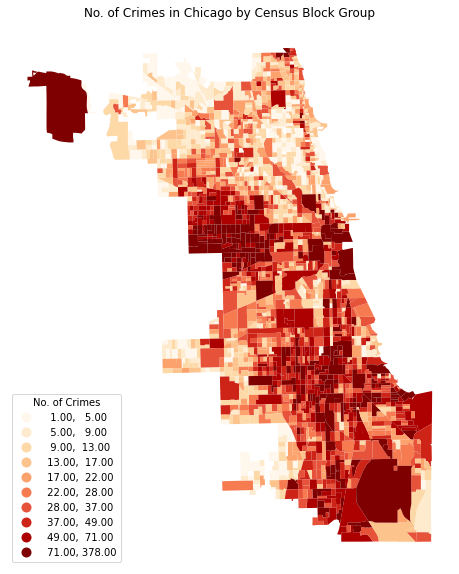

In [55]:
f, ax = plt.subplots(figsize=(10,10))
chicago_crime_blockgroup_count.plot(ax = ax, column = "crime_count", legend = True, cmap = "OrRd", scheme = "quantiles", k = 10, 
                               legend_kwds = {
                                   'loc': 3,
                                   'title': 'No. of Crimes'
                               })
ax.set_axis_off()
ax.set_title("No. of Crimes in Chicago by Census Block Group")
plt.show()


Even within the top decile, the range is remarkably huge. What about at the scale of census blocks, which is even more detailed than census block groups?  
  
Since we do not have Census Block shapefiles on Fidap, what we can do is to pull them from Chicago's Open Data Portal as I have done above, and run a spatial join between the violent crime and Census Block datasets. In this particular case, the spatial join tells us the Census Block where each crime was committed by associating and intersecting the `geometry` column present in both. Once we can ascertain the Census Block where each crime was committed, we can then group them by Census Block and count the number of crimes per Block.

<AxesSubplot:xlabel='case_number', ylabel='Count'>

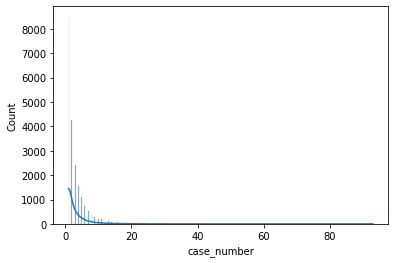

In [83]:
# slimming down the geodataframe for easier spatial joins
chicago_census_blocks_min = chicago_census_blocks.copy().loc[:,["geoid10", "geometry"]]

# running spatial join to figure out which census block each crime is in 
chicago_crime_census_blocks = gpd.sjoin(chicago_violent_crime_2020_gdf, chicago_census_blocks_min, how = "inner", op = "intersects")

# enumerating the number of crimes per census block
chicago_crime_census_blocks_count = chicago_crime_census_blocks.groupby("geoid10").agg('count').loc[:, ['case_number']].reset_index()

# creating geodataframe as geometry columns were lost earlier
chicago_crime_census_blocks_count = chicago_crime_census_blocks_count.merge(chicago_census_blocks_min)
chicago_crime_census_blocks_count = gpd.GeoDataFrame(chicago_crime_census_blocks_count, geometry='geometry', crs='epsg:4326')

# plotting the crime count by census block
sns.histplot(chicago_crime_census_blocks_count, x = "case_number")

In [88]:
print("Highest no. of crimes by Census Block: " + str(chicago_crime_census_blocks_count.case_number.max()))
print("90th percentile of no. of crimes by Census Block: " + str(chicago_crime_census_blocks_count.case_number.quantile(0.9)))
print("95th percentile of no. of crimes by Census Block: " + str(chicago_crime_census_blocks_count.case_number.quantile(0.95)))

Highest no. of crimes by Census Block: 93
90th percentile of no. of crimes by Census Block: 7.0
95th percentile of no. of crimes by Census Block: 10.0


Again, what we see is that there is an extremely long tail where there are some Census Blocks with an extremely high number of violent crimes. We can filter for those in the 90th percentile.

In [112]:
# filtering for census blocks with very high crime counts
top_crime_census_blocks = chicago_crime_census_blocks_count.loc[chicago_crime_census_blocks_count.case_number > chicago_crime_census_blocks_count.case_number.quantile(0.95),:]

Even within the top 5% of Census Blocks ranked by the number of violent crimes, there is a highly uneven distribution, right-skewed distribution of violent crimes by Census Blocks.

<AxesSubplot:xlabel='case_number', ylabel='Count'>

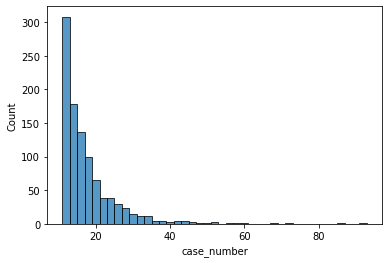

In [113]:
# plotting the crime count by census block
sns.histplot(top_crime_census_blocks, x = "case_number", binwidth=2)

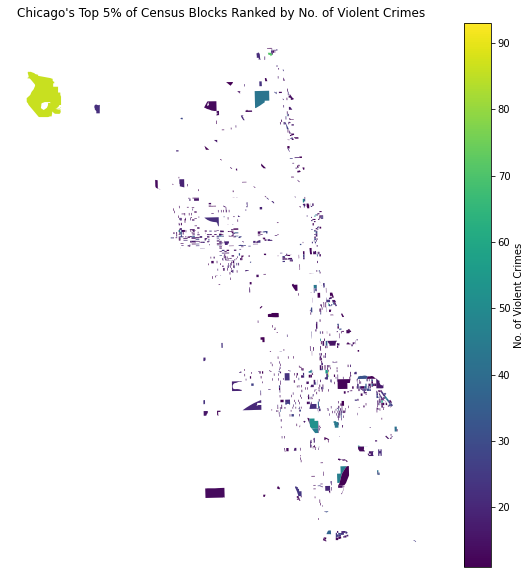

In [114]:
f, ax = plt.subplots(figsize=(10,10))
top_crime_census_blocks.plot(ax = ax, column = "case_number", legend = True,  
                               legend_kwds = {
                                   'label': 'No. of Violent Crimes',
                                   'orientation': 'vertical'
                               })
ax.set_axis_off()
ax.set_title("Chicago's Top 5% of Census Blocks Ranked by No. of Violent Crimes")
plt.show()

If we were to sum up the number of crimes,

In [115]:
print("Total No. of Violent Crimes in Chicago in 2020: " + str(chicago_violent_crime_2020.shape[0]))
print("Total No. of Violent Crimes in Top 5% of Census Blocks Ranked by Incidence of Violent Crimes: " + str(top_crime_census_blocks.case_number.sum()))
print("In other words, 5% of Chicago's Census Blocks accounted for " + str(round(100*top_crime_census_blocks.case_number.sum()/chicago_violent_crime_2020.shape[0],2)) + "% of all violent crimes in Chicago in 2020." )

Total No. of Violent Crimes in Chicago in 2020: 69128
Total No. of Violent Crimes in Top 5% of Census Blocks Ranked by Incidence of Violent Crimes: 17082
In other words, 5% of Chicago's Census Blocks accounted for 24.71% of all violent crimes in Chicago in 2020.


To echo Denver Department of Public Safety's original assertion that 1.5% of Denver's landmass accounts for 20% of its violence in 2020, we can also say that

In [123]:
print(str(round(100*sum(top_crime_census_blocks.to_crs('epsg:3857').geometry.area)/sum(chicago_census_blocks.to_crs('epsg:3857').geometry.area),2)) + "% of Chicago's landmass accounted for " + str(round(100*top_crime_census_blocks.case_number.sum()/chicago_violent_crime_2020.shape[0],2)) + "% of all violent crimes in Chicago in 2020.")

5.68% of Chicago's landmass accounted for 24.71% of all violent crimes in Chicago in 2020.


c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % k_q, UserWarning)


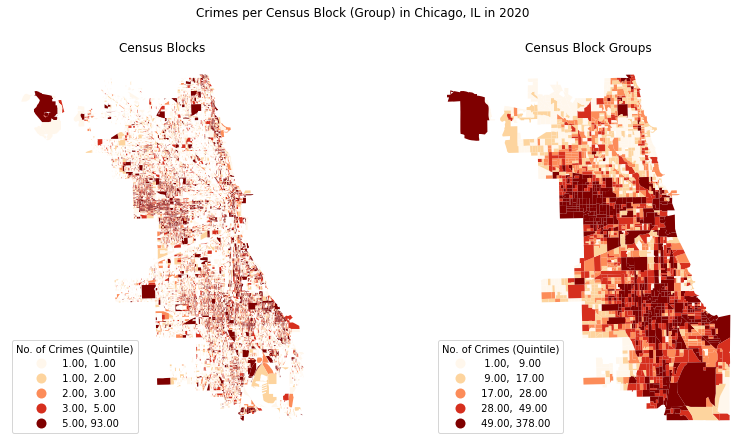

In [79]:
"""
f4, ax4 = plt.subplots(1,2, figsize=(14,7))
chicago_crime_census_blocks_count.plot(ax = ax4[0], column = "case_number", legend = True, cmap = "OrRd", scheme = "quantiles", k = 6, 
                               legend_kwds = {
                                   'loc': 3,
                                   'title': 'No. of Crimes (Quintile)'
                               })
chicago_crime_blockgroup_count.plot(ax = ax4[1], column = "crime_count", legend = True, cmap = "OrRd", scheme = "quantiles", k = 5, 
                               legend_kwds = {
                                   'loc': 3,
                                   'title': 'No. of Crimes (Quintile)'
                               })
for ax in ax4:
    ax.set_axis_off()
ax4[0].set_title("Census Blocks")
ax4[1].set_title("Census Block Groups")
f4.suptitle("Crimes per Census Block (Group) in Chicago, IL in 2020")
plt.show()
"""